# HW05: Predictive Models

## Setup

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

Run the following cell if you need to install the PyTorch or Transformers libraries on a lab computer:

In [1]:
%pip install diffusers transformers accelerate safetensors torchvision --upgrade
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124 --upgrade

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu124

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


This code imports the libraries we need to run our inference pipelines:

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


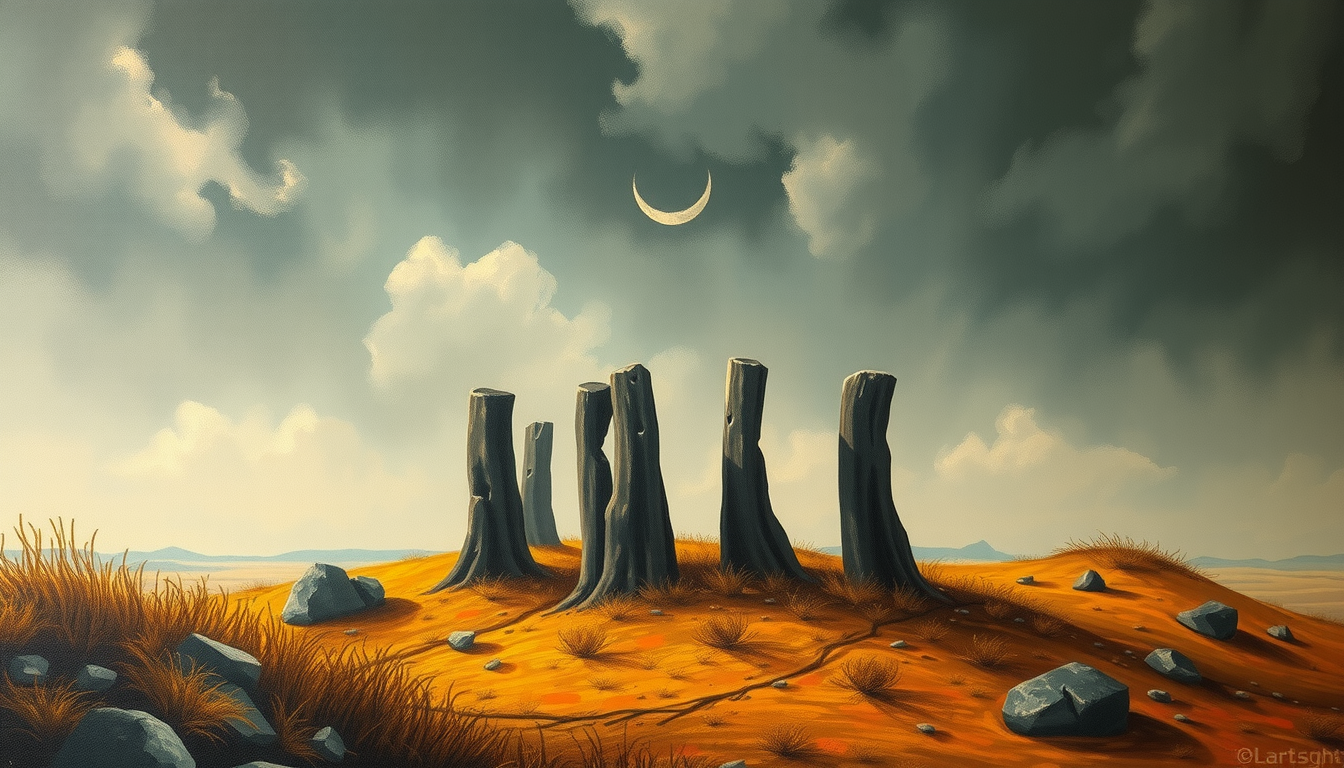

[{'label': 'human', 'score': 0.9875863790512085},
 {'label': 'AI-generated', 'score': 0.012413633055984974}]

In [2]:
from transformers import pipeline
from PIL import Image as PImage

pipe = pipeline('image-classification', model="dima806/ai_vs_human_generated_image_detection")

image = PImage.open('Nov20_emotion_2.jpeg')
#image = PImage.open('josephine-baker-Alexander_Calder.jpg')
display(image)

pipe(image)

In [13]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

url = "https://images.unsplash.com/photo-1517404215738-15263e9f9178?q=80&w=2670&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
image = Image.open(requests.get(url, stream=True).raw)

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected cell phone with confidence 0.994 at location [96.8, 367.07, 2048.19, 1684.81]


In [4]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
inputs = tokenizer("The salmon bread was amazing. I loved it so much.", return_tensors="pt")
inputs = tokenizer("I don't understand why the music has to be so loud in this cafe.", return_tensors="pt")
inputs = tokenizer("wow, today's whether is so nice. It's like I am going to get cold in a second.", return_tensors="pt")
inputs = tokenizer("Oh, what a magnificent day—I've always dreamed of becoming a human popsicle!", return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'POSITIVE'

In [1]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

test_texts = [
    "I absolutely loved the taco! It was so good.", #english text
    "I absolutely loved the taco! It was soooooo good.", #english text
    "I absolutely loved the taco! It was really delicious.", #english text
    "J'ai vraiment adoré le taco ! C'était incroyable.", #french text
    "The dinner was average, neither good nor bad.", #neutral sentiment, english
    "Le dîner était moyen, ni bon ni mauvais.", #netrual, french
    "Oh, wonderful, another freezing day. Just what I needed.",  # Sarcasm sentiment
    "It was a great experience, though the wait was sooo long!", #kind of neutral
    "This is my first time using this brand. I tend to use much more expensive /well known brands but my favorite was sold out, so I did extensive research and decided to try Kiehls. It is definitely moisturizing and has a very light feeling on the skin. There's no real scent at all, which is nice. It has a creamy white texture and feels great going on, and it sinks after a couple of minutes, so it doesn't interfere with other treatments or foundation. It isn't sticky but I would only use it as a cold season moisturizer because I tend to get oily in warmer months. It is something I will probably buy each winter because I am impressed for this price!", #amazon's positive review (review: 4.8*****(25,771))
    "New packaging states still 4.2 oz. Look at the difference in the jar sizes. There is just no way you’re getting the same amount of product. I feel ripped off.", #Amazon's negative review (review: 1.0*(1))
    "This is a piece of Tinguely's “self-constructing and self-destroying work of art,” an enormous kinetic sculpture composed of bicycle wheels, motors, a player piano, a go-cart, a bathtub, and other found objects. The machine was set in motion on March 18, 1960, before an audience in MoMA's Sculpture Garden.", #artwork description (neutral)
    "Ultra-hydrating facial cream with 4.5% Squalane and Glacial Glycoprotein for uniquely boosted and deeply hydrated skin. Works to reduce redness and infuse a calming sensation, for a healthier-looking complexion.", #product description
    "Use after cleansing and toning. Apply dime-sized amount to skin and massage until absorbed." #Suggested use
]

for text in test_texts:
    result = sentiment_pipeline(text)
    print(f"Input: {text}\nOutput: {result}\n")

Device set to use cpu


Input: I absolutely loved the taco! It was so good.
Output: [{'label': 'POSITIVE', 'score': 0.9998785257339478}]

Input: I absolutely loved the taco! It was soooooo good.
Output: [{'label': 'POSITIVE', 'score': 0.9998747110366821}]

Input: I absolutely loved the taco! It was really delicious.
Output: [{'label': 'POSITIVE', 'score': 0.9998830556869507}]

Input: J'ai vraiment adoré le taco ! C'était incroyable.
Output: [{'label': 'NEGATIVE', 'score': 0.884181022644043}]

Input: The dinner was average, neither good nor bad.
Output: [{'label': 'NEGATIVE', 'score': 0.9314054250717163}]

Input: Le dîner était moyen, ni bon ni mauvais.
Output: [{'label': 'POSITIVE', 'score': 0.6998422145843506}]

Input: Oh, wonderful, another freezing day. Just what I needed.
Output: [{'label': 'POSITIVE', 'score': 0.9998562335968018}]

Input: It was a great experience, though the wait was sooo long!
Output: [{'label': 'POSITIVE', 'score': 0.9946223497390747}]

Input: This is my first time using this brand. I

## Depth [Prediction](https://huggingface.co/depth-anything/Depth-Anything-V2-Base-hf)

In [6]:
depth_estimator = pipeline(
  task="depth-estimation",
  model="depth-anything/Depth-Anything-V2-Base-hf"
)

Device set to use cpu


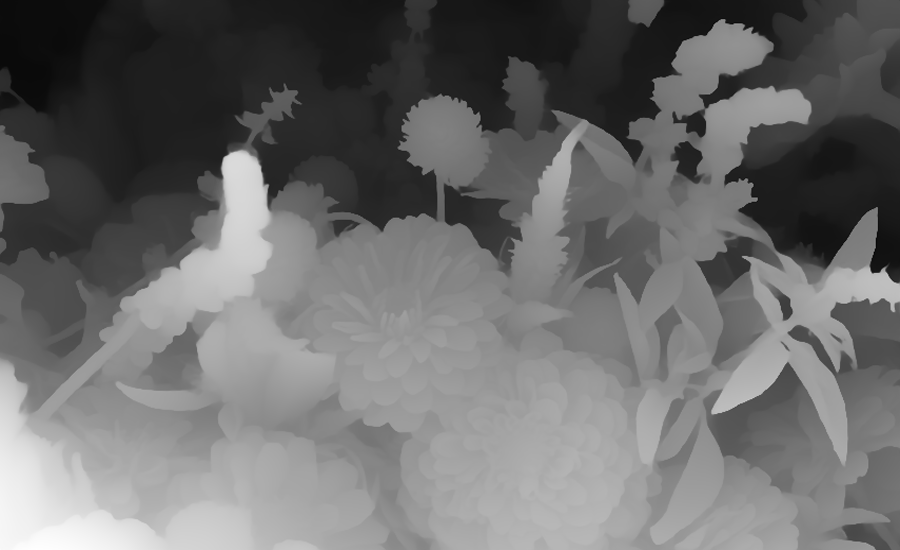

In [7]:
image = Image.open("./imgs/flowers.jpg")
result = depth_estimator(image)
display(result["depth"])

## Object [Detection](https://huggingface.co/facebook/detr-resnet-101)

Some models don't work with the pipeline inference object, but the Transformers library still has some consistent-ish interfaces for running these models.

In [8]:
OBJ_MODEL = "facebook/detr-resnet-101"
detr_processor = DetrImageProcessor.from_pretrained(OBJ_MODEL)
detr_model = DetrForObjectDetection.from_pretrained(OBJ_MODEL)

Some weights of the model checkpoint at facebook/detr-resnet-101 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
image = Image.open("./imgs/people.jpg")
iw, ih = image.size

detr_inputs = detr_processor(images=image, return_tensors="pt")

detr_output = detr_model(**detr_inputs)
detr_results = detr_processor.post_process_object_detection(detr_output, 0.99, [(ih, iw)])

display(detr_results)

[{'scores': tensor([0.9995, 0.9942, 0.9951, 0.9993, 0.9944, 0.9977],
         grad_fn=<IndexBackward0>),
  'labels': tensor([ 1,  1, 77,  1,  1, 64]),
  'boxes': tensor([[413.6277,  45.5431, 525.1335, 396.0908],
          [551.3812, 133.6239, 565.6740, 184.6238],
          [462.7809, 139.5751, 475.0023, 151.8354],
          [307.1216,  50.7288, 401.6793, 394.2442],
          [572.8370, 134.4498, 589.9800, 179.6407],
          [ 57.6269, 161.1983, 136.7103, 257.9586]], grad_fn=<IndexBackward0>)}]

In [10]:
# Turn label ids into labels
for label_id in detr_results[0]["labels"]:
  print(detr_model.config.id2label[int(label_id)])

person
person
cell phone
person
person
potted plant
